In [6]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
from utils import drop_repeat,cal_cross_validated,generate_marker,BlurPooling1D
np.set_printoptions(suppress=True)
from keras.utils import CustomObjectScope
%matplotlib inline

/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/hu/.pyenv/versions/3.6.6/envs/Biosignals/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [7]:
def plot_scatter(df_crossed,pool_factor,x="accuracy",y="consis_b"):
    plt.title(str(pool_factor) + " Layer CNN",fontsize=20)
    for row in df_crossed[df_crossed.pool_factor==pool_factor].iterrows():
        marker = row[1]["marker"]
        label = row[1]["pool_type"]
        _x = row[1][x]
        _y = row[1][y]
        pool_factor = row[1]["pool_factor"]
        if pool_factor == 1:
            edge_color = "b"
        elif pool_factor == 2:
            edge_color = "r"
        elif pool_factor == 3:
            edge_color = "purple"
        c = 'w'
        if marker == "|":
            c = edge_color
        plt.scatter(x=_x,y=_y,marker=marker,c=c,edgecolors=edge_color,s=100,label=label)

## Read result dataframe (CNN)

In [8]:
result_roots = ["./Result_CNN_pool1/","./Result_CNN_pool2/","./Result_CNN_pool3/"]

In [9]:
result_files = []
for result_root in result_roots:
    result_dirs = [os.path.join(result_root,i) for i in os.listdir(result_root) if "results" in i]
    for result_dir in result_dirs:
        result_file = os.path.join(result_dir,"new_result.csv")
        if os.path.exists(result_file):
            result_files.append(result_file)
result_files.sort()

In [10]:
dfs = []
for file in result_files:
    df = pd.read_csv(file)
    df = df.drop(['_'],axis=1)
    pool_type = list(df["pool_type"])[0]
    if pool_type == "maxblur-":
        df["pool_type"] = ["avg" for i in range(len(df))]
        pool_type = "avg"
    df["marker"] = [generate_marker(pool_type) for i in range(len(df))]
    dfs.append(df)
result_df = pd.concat(dfs)

In [11]:
result_df.head()

,idx,pool_factor,pool_type,cross_idx,repeat_idx,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s,marker
0,2,1,max,0,1,1.267224,0.831081,0.797629,0.772520,0.772447,0.772534,0.822811,$M$
1,14,1,max,1,3,1.258857,0.772727,0.740067,0.845580,0.535488,0.905061,0.944646,$M$
2,24,1,max,2,3,0.452523,0.893333,0.861284,0.737744,0.988930,0.690847,0.733638,$M$
3,32,1,max,3,1,0.100253,0.952055,0.943946,0.914907,0.979087,0.903252,0.908806,$M$
4,42,1,max,4,1,0.490812,0.856164,0.830203,0.701976,0.890881,0.667674,0.769526,$M$


In [12]:
result_df_crossed = cal_cross_validated(result_df,cross=5)

In [13]:
result_df_crossed[result_df_crossed.pool_factor==1]

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s
0,1,max,$M$,0.713934,0.861072,0.834626,0.794545,0.833367,0.787874,0.835886
1,1,avg,$A$,0.742720,0.803283,0.791578,0.793278,0.725950,0.805828,0.857205
2,1,maxblur-1,o,0.666554,0.850241,0.830813,0.761357,0.847625,0.745346,0.814000
3,1,maxblur-2,|,0.698139,0.850962,0.838633,0.808865,0.816467,0.807926,0.860799
4,1,maxblur-3,^,0.647956,0.865392,0.857947,0.802245,0.855034,0.792787,0.860861
5,1,maxblur-4,D,0.623882,0.866571,0.848593,0.832316,0.834662,0.832080,0.862523
6,1,maxblur-5,p,0.537061,0.850514,0.839456,0.776680,0.874656,0.758661,0.804257
7,1,maxblur-6,h,0.521779,0.856051,0.848762,0.831136,0.812007,0.834426,0.885516
8,1,maxblur-7,*,0.472173,0.875873,0.866577,0.867690,0.843172,0.872402,0.889983


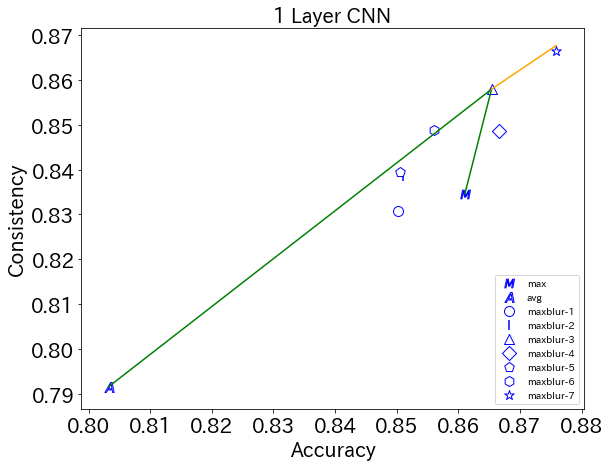

In [14]:
plt.figure(figsize=(9,7))
plt.plot([0.861072,0.865392],[0.834626,0.857947],c="g")
plt.plot([0.803283,0.865392],[0.791578,0.857947],c="g")
plt.plot([0.865392,0.875873],[0.857947,0.867690],c="orange")
plot_scatter(result_df_crossed,pool_factor=1,x="accuracy",y="consis_b")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

In [15]:
result_df_crossed[result_df_crossed.pool_factor==2]

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s
9,2,max,$M$,1.368572,0.805437,0.767876,0.705843,0.849199,0.679532,0.686554
10,2,avg,$A$,0.950490,0.759791,0.761461,0.732621,0.856844,0.709344,0.666078
11,2,maxblur-1,o,1.222878,0.783320,0.794866,0.758087,0.854311,0.740572,0.735421
12,2,maxblur-2,|,0.830678,0.795700,0.795780,0.774164,0.840169,0.762019,0.751391
13,2,maxblur-3,^,0.748060,0.807476,0.788393,0.819983,0.784144,0.827193,0.792641
14,2,maxblur-4,D,0.630656,0.802917,0.793213,0.826496,0.775140,0.835883,0.811285
15,2,maxblur-5,p,0.435832,0.848765,0.838152,0.838314,0.892766,0.828092,0.783539
16,2,maxblur-6,h,0.620134,0.781403,0.775298,0.732462,0.899038,0.701325,0.651559
17,2,maxblur-7,*,0.495870,0.853938,0.848370,0.838991,0.889841,0.829502,0.806899


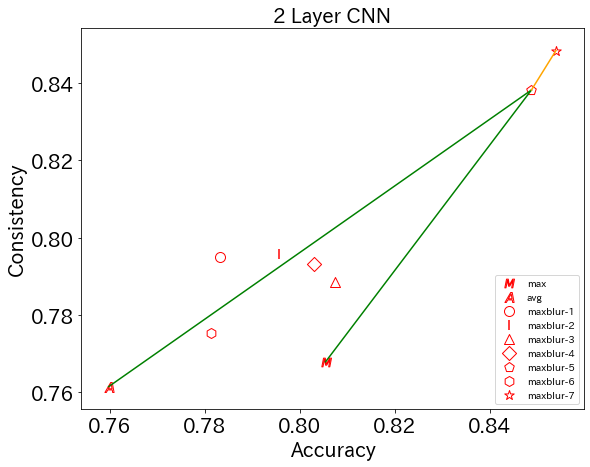

In [16]:
plt.figure(figsize=(9,7))
plt.plot([0.805437,0.848765],[0.767876,0.838152],c="g")
plt.plot([0.759791,0.848765],[0.761461,0.838152],c="g")
plt.plot([0.848765,0.853938],[0.838152,0.848370],c="orange")
plot_scatter(result_df_crossed,pool_factor=2,x="accuracy",y="consis_b")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

In [17]:
result_df_crossed[result_df_crossed.pool_factor==3]

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_ub,consis_n,consis_a,consis_a_s
18,3,max,$M$,1.109113,0.777007,0.765180,0.767980,0.738013,0.773551,0.792348
19,3,avg,$A$,0.686908,0.815080,0.802032,0.812912,0.784708,0.818011,0.819355
20,3,maxblur-1,o,1.058010,0.753697,0.756035,0.726086,0.811998,0.710300,0.700071
21,3,maxblur-2,|,0.654197,0.798680,0.788043,0.693212,0.842906,0.665561,0.733181
22,3,maxblur-3,^,0.437669,0.877807,0.862207,0.786984,0.908118,0.764453,0.816295
23,3,maxblur-4,D,0.379758,0.874326,0.877766,0.762651,0.919285,0.733664,0.836248
24,3,maxblur-5,p,0.411431,0.876357,0.875780,0.815060,0.907238,0.797752,0.844322
25,3,maxblur-6,h,0.420192,0.836023,0.851613,0.811564,0.884555,0.797820,0.818671
26,3,maxblur-7,*,0.442363,0.838255,0.851155,0.821408,0.894208,0.807946,0.808102


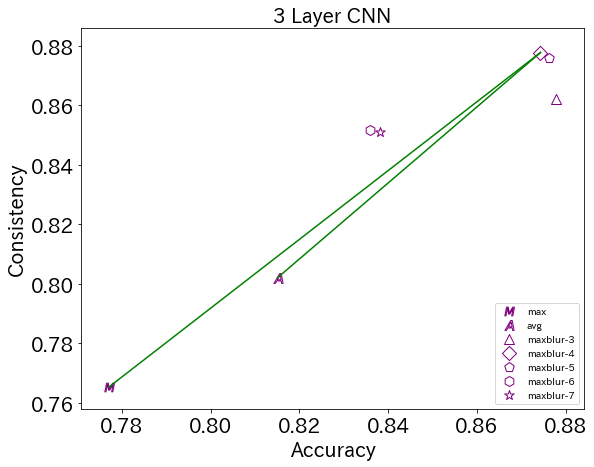

In [22]:
plt.figure(figsize=(9,7))
plt.plot([0.777007,0.874326],[0.765180,0.877766],c="g")
plt.plot([0.815080,0.874326],[0.802032,0.877766],c="g")
plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&(result_df_crossed.pool_type!="maxblur-2")],pool_factor=3,x="accuracy",y="consis_b")
plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Consistency",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right")

In [46]:
def compare_consistency(result_df,pool_type):
    plt.subplot(131)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_a",capsize=0.15
               ,linewidth=2.5, facecolor="w",errcolor=".2", edgecolor="g")
    plt.ylim(0,1)
    plt.xticks([])
    plt.ylabel("Consistency",fontsize=15)
    plt.xlabel("AF",fontsize=15)

    plt.subplot(132)
    plt.title(pool_type,fontsize=15)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_b",capsize=0.15,color="g")
    plt.ylim(0,1)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("")
    
    plt.xlabel("Total",fontsize=15)

    plt.subplot(133)
    sns.barplot(data=result_df[result_df.pool_type==pool_type],x="pool_type",y="consis_n",capsize=0.15
               ,linewidth=2.5, facecolor="w",
                errcolor=".2", edgecolor="g")
    plt.ylim(0,1)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("")
    plt.xlabel("Normal",fontsize=15)
    plt.show()

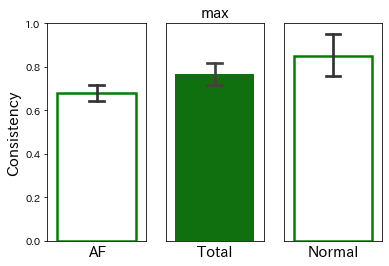

In [47]:
compare_consistency(result_df[result_df.pool_factor==2],pool_type="max")

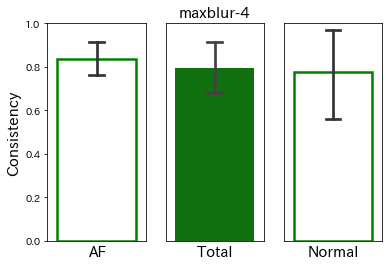

In [53]:
compare_consistency(result_df[result_df.pool_factor==2],pool_type="maxblur-4")

## Plot Blur Filter

In [ ]:
def Get_BlurFilter(filt_size):
    if(filt_size==1):
        return np.array([1.,])
    elif(filt_size==2):
        return np.array([1., 1.])
    elif(filt_size==3):
        return np.array([1., 2., 1.])
    elif(filt_size==4):    
        return np.array([1., 3., 3., 1.])
    elif(filt_size==5):    
        return np.array([1., 4., 6., 4., 1.])
    elif(filt_size==6):    
        return np.array([1., 5., 10., 10., 5., 1.])
    elif(filt_size==7):    
        return np.array([1., 6., 15., 20., 15., 6., 1.])

In [ ]:
blur_size = 5
for blur_size in [i+2 for i in range(6)]:
    print(blur_size)
    plt.figure(figsize=(1,5))
    _filter = np.expand_dims(Get_BlurFilter(blur_size),axis=0)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(_filter,cmap="Greys")

In [ ]:
import matplotlib
plt.figure(figsize=(1,1))
cmap = matplotlib.cm.Greys
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.imshow(np.expand_dims(np.array([.5,.5,.5,.5]),axis=0),cmap=cmap,norm=norm)
#plt.colorbar()
plt.xticks([])
plt.yticks([])